In [1]:
import dsds.prescreen as ps
import dsds.utils as u
import dsds.transform as t
import dsds.encoders as enc
import dsds.sample as sa
import dsds.fs as fs
import polars as pl

# More Complicated Pipelines that are Beyond Sklearn

This is a more advanced pipeline. It contains filter, upsample steps, which are persisted which means they will be remembered by the pipeline and will be
applied if the pipeline is applied to other dataframe. You can set persist = False so that these steps won't be remembered. You can also append a model score to the dataframe. That means this model score append can be an intermediate step, which enables pipelines in which the final model depends on previous model scores. Simple passthroughs like logistic passthrough is built in for you.

In [2]:
# `data` is Lazy because input is Lazy. All pipe functions work with LazyFrames
data = (
    pl.scan_csv("../data/advertising.csv").sort(by="id")
    .pipe(ps.remove_by_var, threshold = 0.5, target = "Clicked on Ad")
    .pipe(ps.filter, condition = pl.col("Age") > 30, persist=True)
    .pipe(ps.remove_constants)
    .pipe(sa.simple_upsample, subgroup = pl.col("One_Hot_Test") != 'A', count = 200, persist=True)
    .pipe(enc.binary_encode, exclude = ["Clicked on Ad"])
    .pipe(enc.one_hot_encode, cols= ["One_Hot_Test"])
    .pipe(t.impute, cols=["Area Income", "Daily Internet Usage", "Daily Internet Usage Band"], strategy="median")
    .pipe(t.impute, cols=["Daily Internet Usage"], strategy = "mean")
    .pipe(u.logistic_passthrough, col = "Daily Internet Usage", coeff=0.5, const=-100.)
    .pipe(fs.mrmr_selector, target = "Clicked on Ad", top_k = 12, strategy="fscore")
    .pipe(fs.mutual_info_selector, target = "Clicked on Ad", top_k = 3)
    .pipe(ps.remove_if_exists, ["Ad Topic Line", "City", "Country", "Timestamp"])
    .pipe(ps.rename, rename_dict={"_logistic":"Daily Internet Usage Logistic Score"}, persist=True)
)


INFO:dsds.prescreen:The following columns are dropped because they have lower than 0.5 variance. ['Male', 'Test_Constant', 'Test_BadColumn'].
Removed a total of 3 columns.
INFO:dsds.prescreen:The following columns are dropped because they are constants. ['Test_Str_Constant'].
Removed a total of 1 columns.
INFO:dsds.fs:Running fscore to determine feature relevance...


Found 13 total features to select from. Proceeding to select top 12 features.


MRMR, fscore: 100%|██████████| 12/12 [00:00<00:00, 11995.15it/s]
INFO:dsds.fs:Selected 12 features. There are 6 columns the algorithm cannot process. They are also returned.


Output is sorted in order of selection (max relevance min redundancy).


Mutual Info: 100%|██████████| 12/12 [00:00<00:00, 144.27it/s]
INFO:dsds.fs:Selected 3 features. There are 5 columns the algorithm cannot process. They are also returned.
INFO:dsds.prescreen:The following columns are dropped. ['Country', 'Timestamp', 'Ad Topic Line', 'City'].
Removed a total of 4 columns.


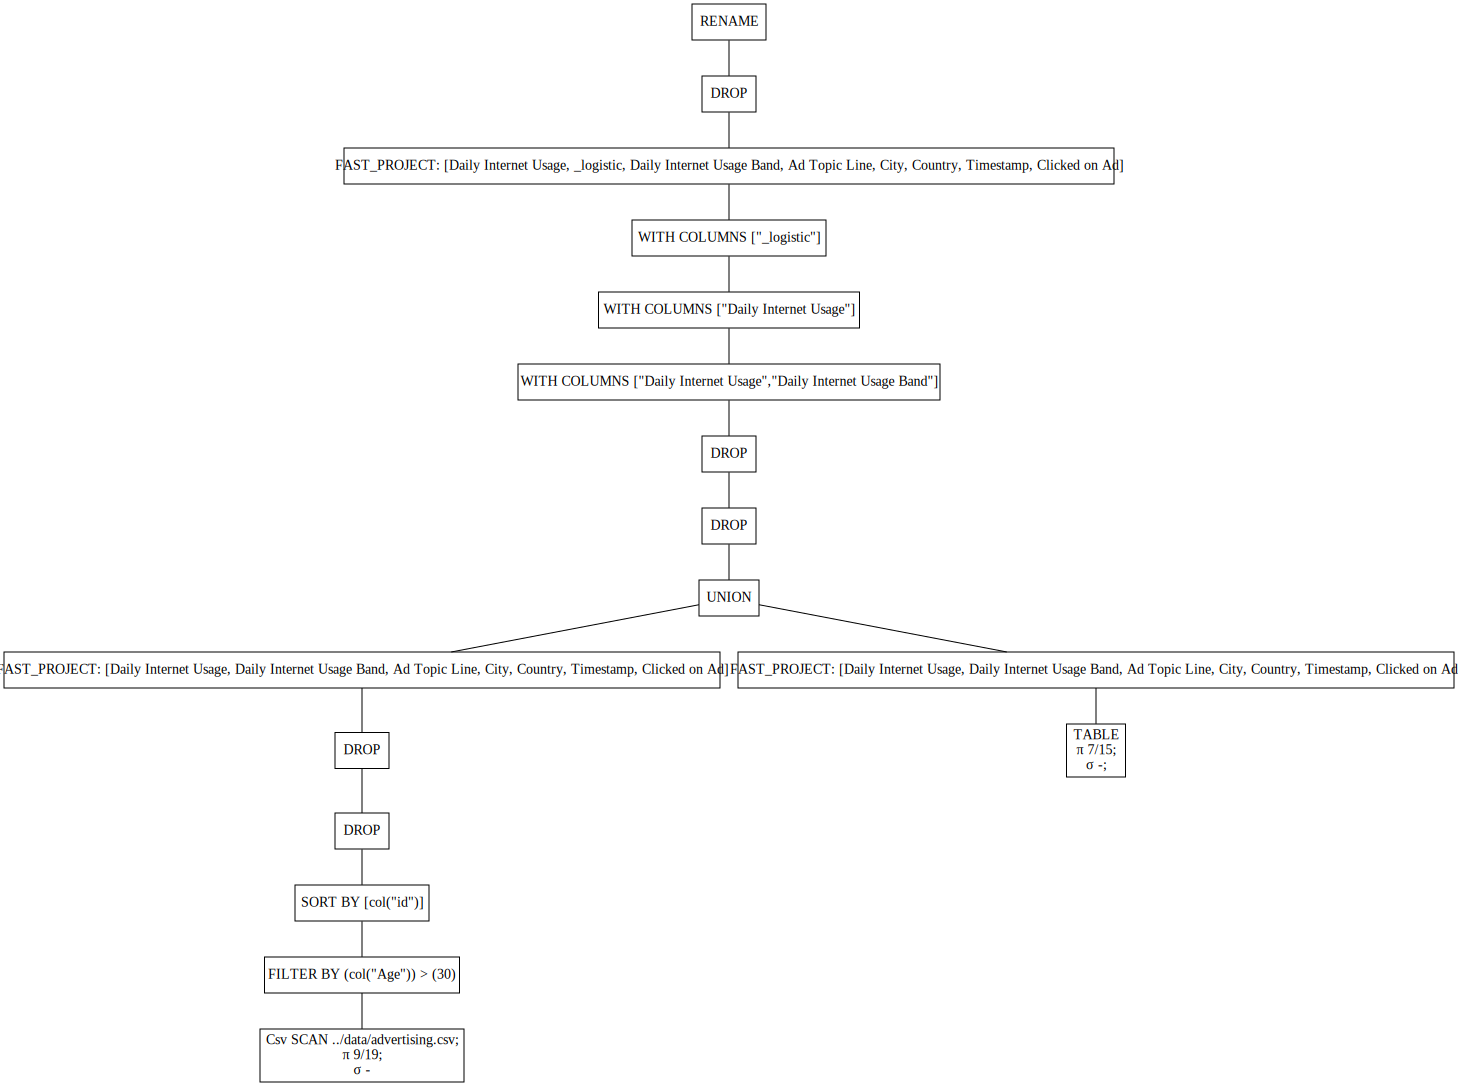

In [3]:
data.show_graph() # Polars magic! Requires graphviz package to be installed

In [4]:
data.limit(5).collect()

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Internet Usage Band,Clicked on Ad
f64,f64,f64,i64
256.09,1.0,12.0,0
193.77,0.042493,9.0,0
225.58,0.999997,11.0,0
208.36,0.984932,10.0,0
131.76,1.5201e-15,6.0,1


In [5]:
features = [c for c in data.columns if c != "Clicked on Ad"]

In [6]:
data.blueprint

Step 0 | Action: drop
['Male', 'Test_Constant', 'Test_BadColumn']

Step 1 | Action: filter
By condition: [(col("Age")) > (30)]


Step 2 | Action: drop
['Test_Str_Constant']

Step 3 | Action: add_func
Function Module: dsds.sample, Function Name: simple_upsample
Parameters:
subgroup = [(col("One_Hot_Test")) != (Utf8(A))],
count = 200,
epsilon = 0.01,
include = None,
exclude = None,
positive = False,
seed = 42,


Step 4 | Action: with_columns
Details: 
(1) .when([(col("Test_Binary")) == (Utf8(B))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("Test_Binary_B")


Step 5 | Action: drop
['Test_Binary']

Step 6 | Action: with_columns
Details: 
(1) .when([(col("One_Hot_Test")) == (Utf8(A))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("One_Hot_Test_A")
(2) .when([(col("One_Hot_Test")) == (Utf8(B))]).then(1.strict_cast(UInt8)).otherwise(0.strict_cast(UInt8)).alias("One_Hot_Test_B")
(3) .when([(col("One_Hot_Test")) == (Utf8(C))]).then(1.strict_cast(UInt8))

In [7]:
x = data.collect()
y = x.drop_in_place("Clicked on Ad")

In [8]:
# Train and tune a model outside the data pipeline
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs= -1)
rf.fit(x.select(features), y)


RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs=-1)

In [9]:
# add the TRAINED model to the end of the data pipeline

final_df = data.pipe(
    u.append_classif_score, 
    model = rf, 
    features = features,
    target = "Clicked on Ad", 
)

In [10]:
# Show last 3 steps.
final_df.blueprint.show(-3)

Step 13 | Action: drop
['Country', 'Timestamp', 'Ad Topic Line', 'City']

Step 14 | Action: add_func
Function Module: dsds.prescreen, Function Name: rename
Parameters:
rename_dict = {'_logistic': 'Daily Internet Usage Logistic Score'},


Step 15 | Action: classif
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Using the features ['Daily Internet Usage', 'Daily Internet Usage Logistic Score', 'Daily Internet Usage Band']
Appends model_score to dataframe.




In [11]:
final_df.limit(5).collect()

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Internet Usage Band,Clicked on Ad,model_score
f64,f64,f64,i64,f64
256.09,1.0,12.0,0,0.069359
193.77,0.042493,9.0,0,0.304376
225.58,0.999997,11.0,0,0.064493
208.36,0.984932,10.0,0,0.107543
131.76,1.5201e-15,6.0,1,0.998192


In [12]:
# The modelled pipeline can be pickled as long as the 
# model can be pickled

final_df.blueprint.preserve("modelled_pipe.pkl")

In [13]:
import dsds.blueprint as bp
pipe = bp.from_pkl("modelled_pipe.pkl")
type(pipe)

dsds.blueprint.Blueprint

In [14]:
processed_df = pipe.apply(
    pl.scan_csv("../data/advertising.csv")
    , collect = True
)

In [15]:
processed_df

Daily Internet Usage,Daily Internet Usage Logistic Score,Daily Internet Usage Band,Clicked on Ad,model_score
f64,f64,f64,i64,f64
256.09,1.0,12.0,0,0.069359
193.77,0.042493,9.0,0,0.304376
225.58,0.999997,11.0,0,0.064493
208.36,0.984932,10.0,0,0.107543
131.76,1.5201e-15,6.0,1,0.998192
122.02,1.1664e-17,6.0,1,0.998192
230.87,1.0,11.0,0,0.032974
113.12,1.3622e-19,5.0,1,0.998192
143.56,5.5489e-13,7.0,1,0.983747
